In [1]:
import h5py

import numpy as np
import matplotlib.pyplot as plt
import fenics as fe

from tqdm import trange
from numpy.testing import assert_allclose

import sys

sys.path.insert(0, "../scripts")

from swe_2d import ShallowTwo, ShallowTwoFilter, ShallowTwoFilterPETSc
from statfenics.utils import build_observation_operator

fe.set_log_level(50)

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
mesh = fe.RectangleMesh(
    fe.MPI.comm_world,
    fe.Point(0, 0), 
    fe.Point(2, 1), 
    32, 16)
mesh_self = fe.RectangleMesh(
    fe.MPI.comm_self,
    fe.Point(0, 0), 
    fe.Point(2, 1), 
    32, 16)
params = {"nu": 1e-5, "C": 0., "H": 0.053, "u_inflow": 0.004, "inflow_period": 120}
control = {"dt": 5e-2,
           "theta": 0.5,
           "simulation": "cylinder",
           "use_imex": False,
           "use_les": False}
swe_numpy = ShallowTwoFilter(mesh, params, control, comm=fe.MPI.comm_world)
swe = ShallowTwoFilterPETSc(mesh, params, control, comm=fe.MPI.comm_world)
assert swe.L == 2.
assert swe.B == 1.

# check that all the dofs line up
assert_allclose(np.unique(swe.W.dofmap().dofs()),
                np.unique(np.concatenate((swe.u_dofs,
                                          swe.v_dofs,
                                          swe.h_dofs))))
swe_numpy.setup_form()
swe.setup_form()
swe_numpy.setup_solver()
swe.setup_solver()

In [3]:
# setup filter (basically compute prior additive noise covariance)
k = 256
rho = 1
ell = 0.2
stat_params = dict(rho_u=rho, rho_v=rho, rho_h=rho,
                   ell_u=ell, ell_v=ell, ell_h=ell,
                   k_init_u=k, k_init_v=k, k_init_h=k, k=k)
swe_numpy.setup_filter(stat_params)

Obs. operator and noise not parsed: setup for prior run ONLY


In [4]:
swe.setup_filter(stat_params)
swe.setup_prior_covariance()

In [5]:
swe_numpy.setup_filter(stat_params)
K_sqrt = swe_numpy.K_sqrt
K_sqrt_petsc = swe.K_sqrt.getDenseArray()
print(np.linalg.norm(K_sqrt - K_sqrt_petsc) / np.linalg.norm(K_sqrt))

Obs. operator and noise not parsed: setup for prior run ONLY


0.001218925205161896


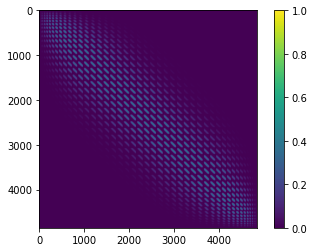

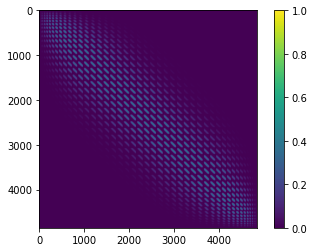

In [6]:
im = plt.imshow(K_sqrt_petsc @ K_sqrt_petsc.T)
plt.colorbar()
plt.show()

im = plt.imshow(K_sqrt @ K_sqrt.T)
plt.colorbar()
plt.show()

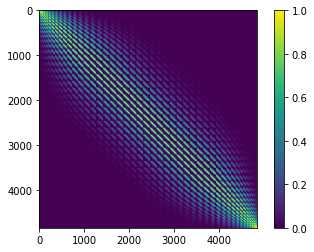

In [7]:
from statfenics.covariance import sq_exp_covariance
K_true = sq_exp_covariance(swe_numpy.W.tabulate_dof_coordinates(), rho, ell) 

im = plt.imshow(K_true)
plt.colorbar(im)
plt.show()

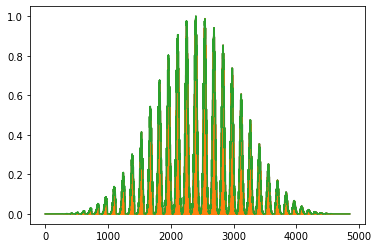

In [8]:
row = 2400
K_approx_petsc = K_sqrt_petsc @ K_sqrt_petsc.T
K_approx = K_sqrt @ K_sqrt.T
plt.plot(K_approx_petsc[row, :])
plt.plot(K_approx[row, :])
plt.plot(K_true[row, :])
plt.show()

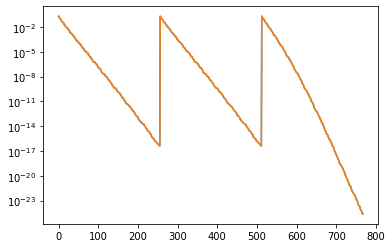

In [9]:
u = fe.TrialFunction(swe.W)
v = fe.TestFunction(swe.W)

M = fe.PETScMatrix()
fe.assemble(fe.inner(u, v) * fe.dx, tensor=M)

from scipy.sparse import csr_matrix
M_scipy = csr_matrix(M.mat().getValuesCSR()[::-1], shape=M.mat().size)

plt.semilogy(
    (K_sqrt[:, :].T @ swe_numpy.M_scipy @ K_sqrt[:, :]).diagonal())
plt.semilogy(
    (K_sqrt_petsc[:, :].T @ M_scipy @ K_sqrt_petsc[:, :]).diagonal())
plt.show()

5.833173993522821


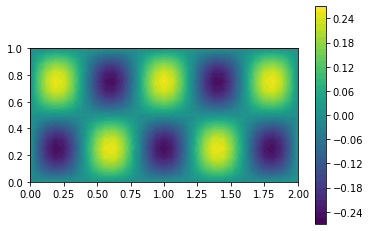

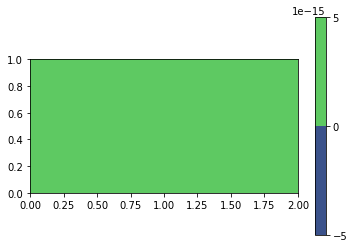

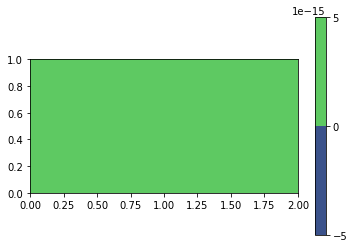

In [10]:
k = 12 
var_f = fe.Function(swe.W)
print(np.linalg.norm(swe.K_sqrt.getDenseArray()[:, k]))
var_f.vector().set_local(swe.K_sqrt.getDenseArray()[:, k])

vel, h = var_f.split()
u, v = vel.split()

im = fe.plot(u)
plt.colorbar(im)
plt.show()

im = fe.plot(v)
plt.colorbar(im)
plt.show()

im = fe.plot(h)
plt.colorbar(im)
plt.show()

In [11]:
element = swe.W.element()
dofmap = swe.W.sub(1).dofmap()
dofmap.local_to_global_index(15)

15